# Лабораторная работа 3

Классификация в sklearn. Метрики классификации

Выполнил: Новицкий Никита (6132-010402D)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from warnings import filterwarnings
filterwarnings("ignore")

Выберите наборы данных, подходящие для многоклассовой и бинарной классификации. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. В общем, проведите "визуальный" анализ ваших данных.

Набор данных: https://www.kaggle.com/datasets/yasserh/bmidataset

In [2]:
df = pd.read_csv("bmi.csv")

In [3]:
df.head(5)

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3


Этот фрейм данных содержит следующие столбцы:

Пол : Мужчина / Женщина

Высота : Количество (см)

Вес: Количество (Кг)

Индекс :

0 - Чрезвычайно Слабый

1 - Слабый

2 - Нормальный

3 - Избыточный вес

4 - Ожирение

5 - Крайнее Ожирение

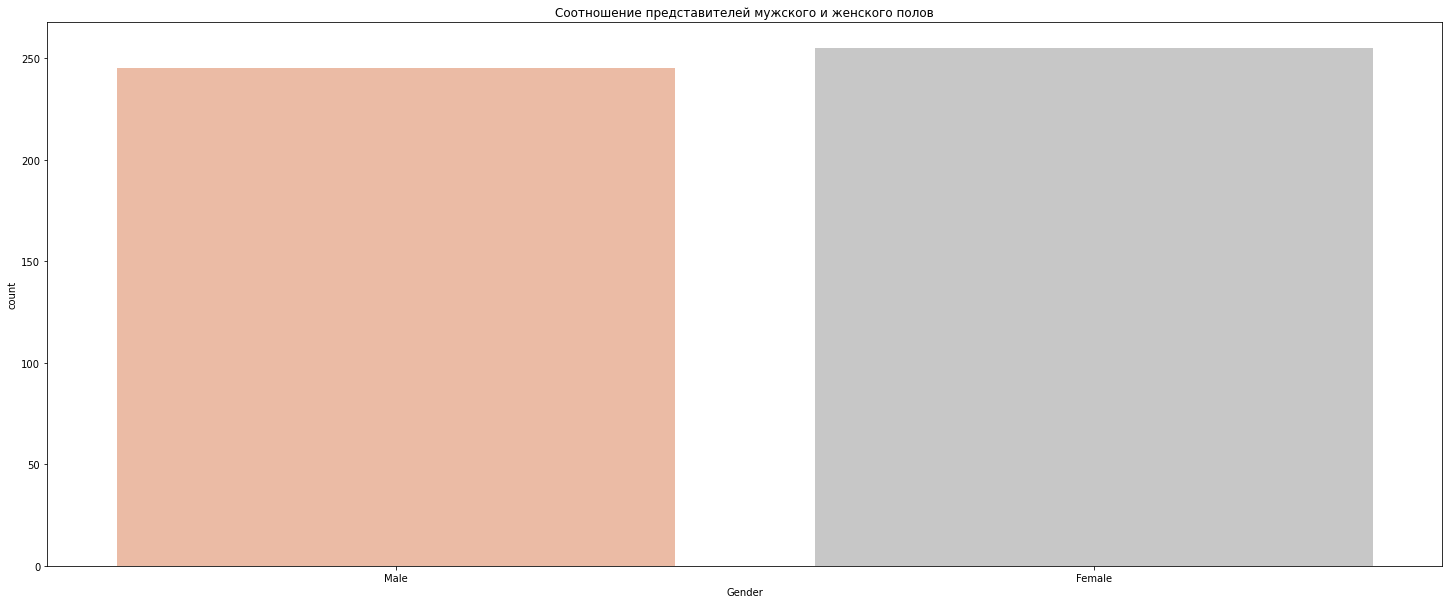

In [4]:
fig, ax = plt.subplots(figsize=(25,10))
sns.countplot(df["Gender"], palette="RdGy")
ax.set(title="Соотношение представителей мужского и женского полов")
plt.show()

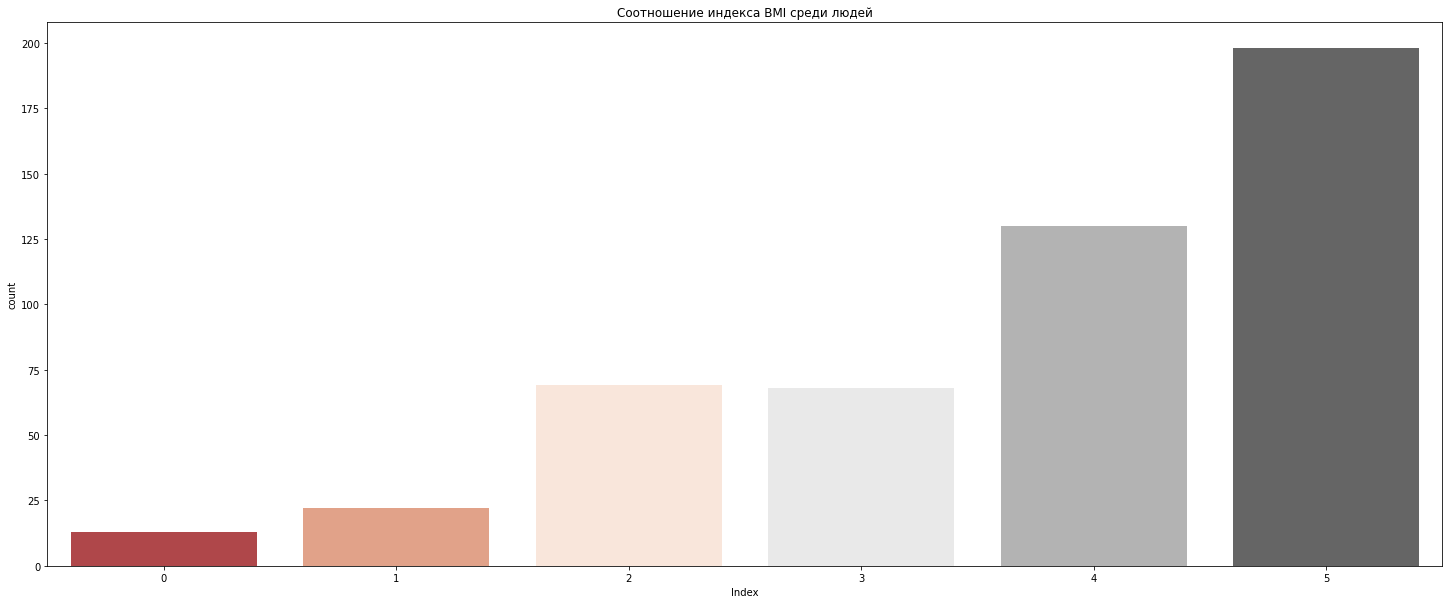

In [5]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.countplot(df["Index"], palette="RdGy")
ax.set(title="Соотношение индекса BMI среди людей")
plt.show()

Посмотрим, имеем ли мы пропущенные значения в нашей выборке

In [6]:
df.isna().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

Пропущенных значений нет, поэтому едем далее

Заменим Male/Female на нули и единицы

In [7]:
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1})

In [8]:
X, y = df.drop("Index", axis=1), df["Index"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=7)

In [10]:
parametrs = {
    "n_neighbors": np.array(range(1, 15, 1)),
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
    "metric": ["minkowski", "euclidean", "manhattan", "chebyshev", "seuclidean", "mahalanobis"]
}

In [11]:
def random_search(model=None, refit="precision_macro", params=parametrs, X=X, y=y): 
    """
    Данная функция позволяет производить подбор гиперпараметров с помощью RandomSearch
    """
    random_search_cv = RandomizedSearchCV(
        model, 
        params, 
        scoring=["f1_macro", "precision_macro", "recall_macro"], 
        n_jobs=-1, 
        cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True), 
        verbose=3, 
        refit=refit
    )
    random_search = random_search_cv.fit(X, y)
    print(f"Best params for {refit}")
    print(random_search.best_params_)

In [12]:
def print_result(y_test=y_test, pred=None):
    print(f"Classification report: \n {classification_report(y_test, pred)}")
    print(f"Confusion matrix: \n {confusion_matrix(y_test, pred)} \n")
    sns.set(font_scale=0.8)
    sns.heatmap(confusion_matrix(y_test, pred), linewidths=.5, cmap="mako", annot=True)

# Классификация без подбора гиперпараметров

In [13]:
KNeighbors = KNeighborsClassifier()
KNeighbors.fit(X_train, y_train)
KNeighborsPredict = KNeighbors.predict(X_test)

In [14]:
score = cross_val_score(KNeighbors, X, y, cv=9, scoring="precision_macro")
print(f"Average precision score without setting hyperparameters: {np.mean(score) * 100:.2f}%")

Average precision score without setting hyperparameters: 89.82%


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.71      0.83      0.77         6
           2       0.87      0.76      0.81        17
           3       0.94      0.88      0.91        17
           4       0.81      0.91      0.86        33
           5       0.94      0.90      0.92        49

    accuracy                           0.88       125
   macro avg       0.88      0.88      0.88       125
weighted avg       0.88      0.88      0.88       125

Confusion matrix: 
 [[ 3  0  0  0  0  0]
 [ 0  5  1  0  0  0]
 [ 0  2 13  1  1  0]
 [ 0  0  1 15  1  0]
 [ 0  0  0  0 30  3]
 [ 0  0  0  0  5 44]] 



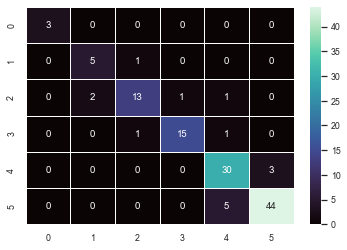

In [15]:
print_result(y_test, KNeighborsPredict)

# Классификация с подбором гиперпараметров

In [16]:
%%time
random_search(model=KNeighbors, refit="precision_macro", params=parametrs, X=X, y=y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for precision_macro
{'weights': 'distance', 'p': 1, 'n_neighbors': 14, 'metric': 'minkowski', 'algorithm': 'ball_tree'}
CPU times: user 114 ms, sys: 133 ms, total: 247 ms
Wall time: 1.53 s


Оптимальные параметрны для KNeighbors: {'weights': 'distance', 'p': 1, 'n_neighbors': 14, 'metric': 'minkowski', 'algorithm': 'ball_tree'}

In [17]:
KNeighborsRandom = KNeighborsClassifier(
    weights="distance", 
    p=2, 
    n_neighbors=14, 
    metric="minkowski", 
    algorithm="ball_tree"
)

KNeighborsRandom.fit(X_train, y_train)
KNeighborsRandomPredict = KNeighborsRandom.predict(X_test)
score = cross_val_score(KNeighborsRandom, X, y, cv=9, scoring='precision_macro')
print(f"Average precision score with hyperparameter setting (RandomSearchcv): {np.mean(score) * 100:.2f}%")

Average precision score with hyperparameter setting (RandomSearchcv): 90.74%


Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.71      0.83      0.77         6
           2       0.76      0.76      0.76        17
           3       0.81      0.76      0.79        17
           4       0.85      0.88      0.87        33
           5       0.96      0.94      0.95        49

    accuracy                           0.87       125
   macro avg       0.85      0.86      0.86       125
weighted avg       0.87      0.87      0.87       125

Confusion matrix: 
 [[ 3  0  0  0  0  0]
 [ 0  5  1  0  0  0]
 [ 0  2 13  1  1  0]
 [ 0  0  3 13  1  0]
 [ 0  0  0  2 29  2]
 [ 0  0  0  0  3 46]] 



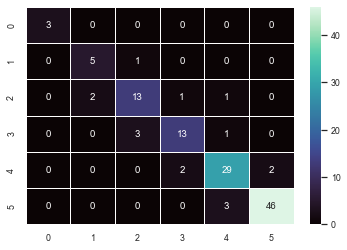

In [18]:
print_result(y_test, KNeighborsRandomPredict)

Поиграться с гиперпараметром, связанным со сложностью модели (в случае kNN — k_neighbours) и построить график accuracy для train set и test_set для разных значений гиперпараметра (в лекции есть пример построения подобного графика для kNN и датасета cancer, но можно строить как угодно такой график)

In [19]:
min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
accuracy_test = []
accuracy_train = []

for number in min_samples_leaf:
    DTC = DecisionTreeClassifier(min_samples_leaf=number)
    
    DTC.fit(X_train, y_train)
    DTCPredict = DTC.predict(X_train)
    accuracy_train.append(accuracy_score(y_train, DTCPredict))
    
    DTC.fit(X_test, y_test)
    DTCPredict = DTC.predict(X_test)
    accuracy_test.append(accuracy_score(y_test, DTCPredict))

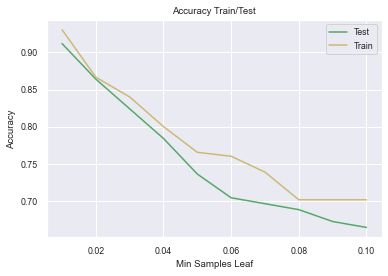

In [20]:
plt.plot(min_samples_leaf, accuracy_test, color="g", label="Test")
plt.plot(min_samples_leaf, accuracy_train, color="y", label='Train')
plt.title("Accuracy Train/Test")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Стоит отметить, что чем больше объектов в листе, чем ниже падает точность, что на тестовой выборке, что на обучающей

Построить confusion matrix (это вроде матрицы TN / TP/ FN/ FP, только расширенной для многоклассовой классификации, чтобы понять в какие стороны чаще ошибается классификатор).

<AxesSubplot:>

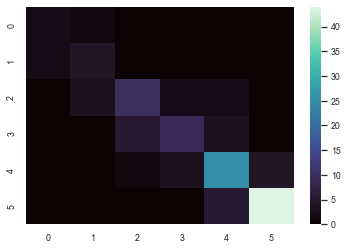

In [21]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)
DTCPredict = DTC.predict(X_test)
sns.heatmap(confusion_matrix(y_test, DTCPredict), cmap="mako")

# Бинарная классификация.

На любом (но уже другом, бинарном) датасете продемонстрировать бинарную классификацию (можно использовать любой алгоритм), посчитать метрики: accuracy, precision, recall, f-measure, а также составить classification_report

In [22]:
X_bin, y_bin = df.drop("Gender", axis=1), df["Gender"]

In [23]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, 
                                                                    y_bin, 
                                                                    test_size=.25, 
                                                                    stratify=y, 
                                                                    random_state=7)

In [24]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

DTC = DecisionTreeClassifier()
DTC.fit(X_train_bin, y_train_bin)
DTCPredict = DTC.predict(X_test_bin)

print(f"Accuracy: {accuracy_score(y_test_bin, DTCPredict)}")
print(f"Precision: {precision_score(y_test_bin, DTCPredict)}")
print(f"Recall: {recall_score(y_test_bin, DTCPredict)}")
print(f"F1-score: {f1_score(y_test_bin, DTCPredict)}")
print(f"Classification report:\n{classification_report(y_test_bin, DTCPredict)}")

Accuracy: 0.464
Precision: 0.4342105263157895
Recall: 0.5789473684210527
F1-score: 0.49624060150375954
Classification report:
              precision    recall  f1-score   support

           0       0.51      0.37      0.43        68
           1       0.43      0.58      0.50        57

    accuracy                           0.46       125
   macro avg       0.47      0.47      0.46       125
weighted avg       0.48      0.46      0.46       125



# Использование нормализации признаков 
В обоих задачах (бинарной и многоклассовой классификации) попробовать также вариант с предварительной нормализацией признаков
(StandardScaler или MinMaxScaler). Оценить метрики качества в случае с нормализованными признаками и ненормализованными.

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_multi_scaler = scaler.fit_transform(X_train)
X_test_multi_scaler = scaler.fit_transform(X_test)

X_train_bin_scaler = scaler.fit_transform(X_train_bin)
X_test_bin_scaler = scaler.fit_transform(X_test_bin)

In [26]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train_multi_scaler, y_train)
DTCPredict = DTC.predict(X_test_multi_scaler)

print(f"Accuracy: {accuracy_score(y_test, DTCPredict)* 100:.2f}%")
print(f"Classification report:\n{classification_report(y_test, DTCPredict)}")

Accuracy: 75.20%
Classification report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       0.50      0.67      0.57         6
           2       0.62      0.59      0.61        17
           3       0.64      0.53      0.58        17
           4       0.71      0.76      0.74        33
           5       0.92      0.90      0.91        49

    accuracy                           0.75       125
   macro avg       0.65      0.68      0.66       125
weighted avg       0.76      0.75      0.75       125



In [27]:
DTC = DecisionTreeClassifier()
DTC.fit(X_train_bin_scaler, y_train_bin)
DTCPredict = DTC.predict(X_test_bin_scaler)

print(f"Accuracy: {accuracy_score(y_test_bin, DTCPredict) * 100:.2f}%")
print(f"Classification report:\n{classification_report(y_test_bin, DTCPredict)}")

Accuracy: 50.40%
Classification report:
              precision    recall  f1-score   support

           0       0.57      0.38      0.46        68
           1       0.47      0.65      0.54        57

    accuracy                           0.50       125
   macro avg       0.52      0.52      0.50       125
weighted avg       0.52      0.50      0.50       125

